Convert ser file to 2D np array

In [32]:
import numpy as np
import matplotlib.pyplot as plt    

Bruker uses little endian for raw files

In [33]:
folder = 'nmr_data/19'

In [34]:
byte_order = 0 # Set the byte order according to the data. 0 for little endian, 1 for big endian
fid_file = folder + '/ser'
if byte_order == 0: # little endian
    dtype = '<i4'
elif byte_order == 1: # big endian
    dtype = '>i4'

with open(fid_file, 'rb') as input_serial_file: 
    raw_data = np.frombuffer(input_serial_file.read(), dtype=dtype)

In [35]:
def read_bruker_param(filename, param):
    with open(filename, "r") as f:
        for line in f:
            if line.startswith(f"##${param}="):
                value = line.split("=", 1)[1].strip()
                return int(value) 
    raise KeyError(f"Parameter {param} not found")
td = folder + '/acqus'
td = read_bruker_param(td, "TD")
num_fid = int(len(raw_data)/td)  # Number of FIDs. Match with your data.
print(num_fid, td)     

256 2048


In [36]:
#getting a single numpy array of all the FIDs (256, 2048). Real and imaginary parts are mixed.
fid2d = []

for i  in range(num_fid):
    a = i * td
    b = (i+1) * td
    fid_data = raw_data[a:b] 
    reals = fid_data[0::2]    
    imags = fid_data[1::2] 
    fid = reals + 1.j*imags
    fid2d.append(fid)

fid2d = np.array(fid2d) # numpy array of all the FIDs (256, 2048). Real and imaginary parts are mixed.
print(fid2d.shape)

(256, 1024)


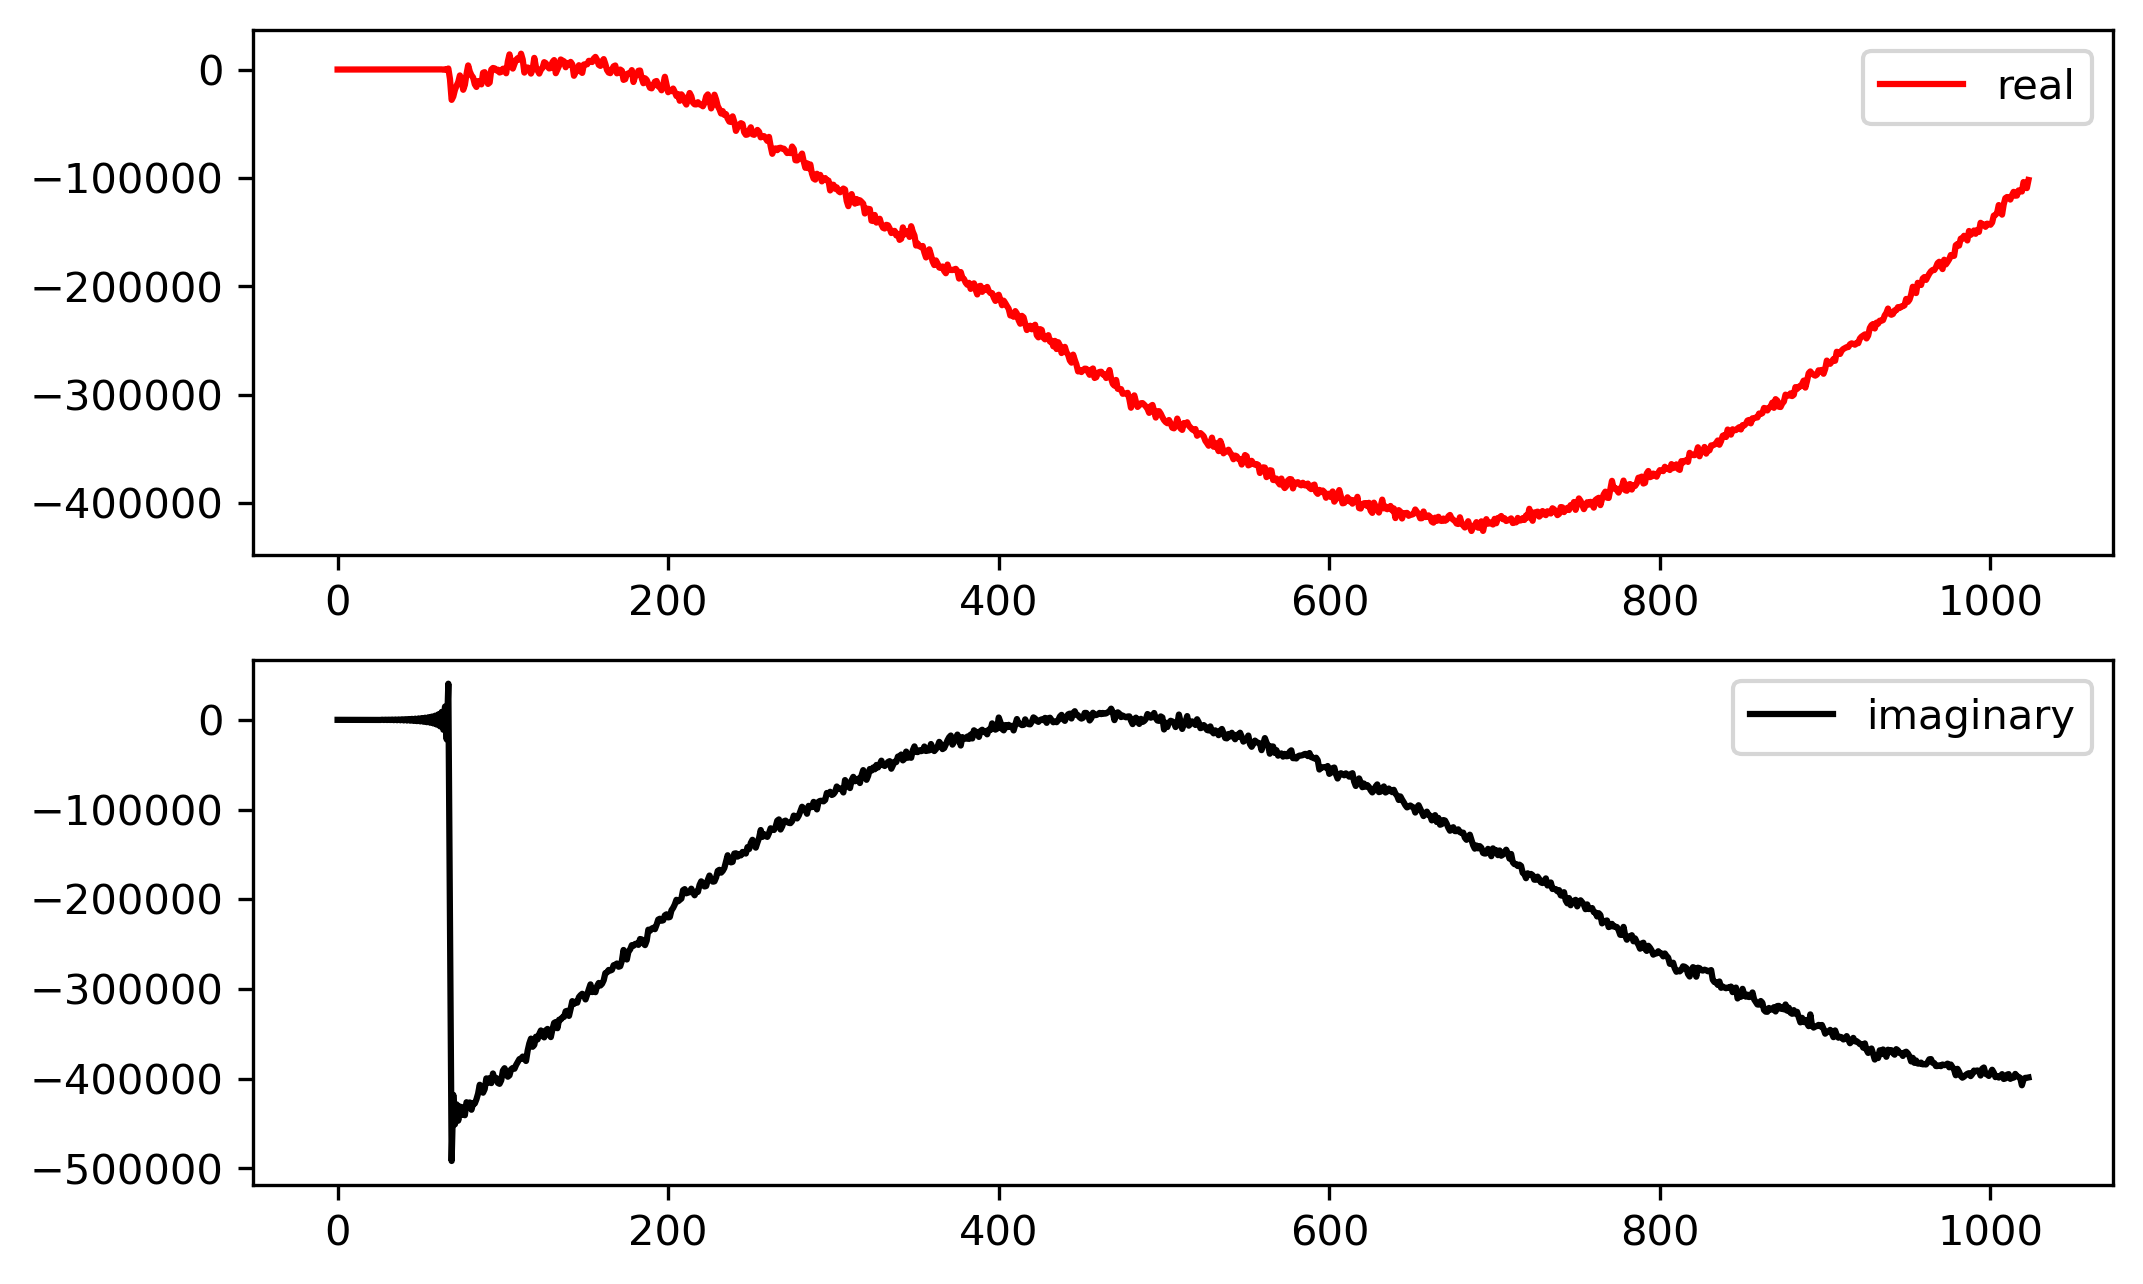

In [37]:
plt.figure(figsize=(8, 5), dpi=300)                   
plt.subplot(2, 1, 1)   
plt.plot(np.real(fid2d[10]), c='r', label='real')  
plt.legend()                                 

plt.subplot(2, 1, 2)                  
plt.plot(np.imag(fid2d[10]),c='k', label='imaginary')
plt.legend()                               

plt.show()   

Converting numpy array to ser binary file

In [38]:
fid_chunks = []

# Iterate through each row in fid2d
for fid in fid2d:
    fid_chunk = np.column_stack((np.real(fid), np.imag(fid))).flatten()
    fid_chunks.append(fid_chunk)

raw_data_reconstructed = np.concatenate(fid_chunks)

# Check the shape of the reconstructed raw_data
print("Shape of Reconstructed raw_data:", raw_data_reconstructed.shape)

Shape of Reconstructed raw_data: (524288,)


In [ ]:
output_file = 'path/to/your/folder/ser'

with open(output_file, 'wb') as output_serial_file: # Conversion of numpy array to ser file. Will be saved at output_file
    output_serial_file.write(np.array(raw_data_reconstructed, dtype=dtype).tobytes())